<a href="https://colab.research.google.com/github/DrSubbiah/1.Bayesian-Inference/blob/master/13_Interpretation_Count_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color="darkblue">Count Data Model

In [ ]:
import numpy as np
import pandas as pd
import statistics as stat
import scipy
import pystan

In [ ]:
#For plots
import arviz as az
import matplotlib.pyplot as plt

#<font color="darkblue"> Loading Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = "/content/drive/MyDrive/Data Sets/BikeSharing_day.csv"
bikeshare_da = pd.read_csv(path)

In [ ]:
bikeshare_da.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2011,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,02-01-2011,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,03-01-2011,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,04-01-2011,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,05-01-2011,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [ ]:
bikeshare_da.columns

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt'],
      dtype='object')

# <font color="darkblue"> Quantity of Interest QoI

- In this data set, QoI is *cnt*, count of total rental bikes including both casual and registered

- A count variable whose range may be $[0,\infty)$

- Interest is to **estimate** the mean number of rentals made by the customer population from the **sample** data

- This may be done without any predictors as a step to summarize the behaviour of QoI

- However, an explantory model may validate any question / uncertainty about the QoI and associations (if any) with predictors

- As usual, it is better to know the nature of the variable to make appropriate summary measures and modeling procedures

#<font color="darkblue"> Poisson GLM with One Numeric Predictor

*temp* is a numeric variable - Normalized Temperature in Celsius

In [ ]:
bikeshare_fit_code1 = """
data {
int<lower=0> N;
int<lower=0> y[N];
vector[N] x;
real a_0;
real b_0;
real a_1;
real b_1;
}

parameters {
real b0;
real b1;
}
model {
y ~ poisson_log(b0 + b1 * x);

b0 ~ normal(a_0,b_0);
b1 ~ normal(a_1,b_1);
}
"""


# Posterior
posterior_fit1 = pystan.StanModel(model_code=bikeshare_fit_code1)


In [ ]:
# Input - data and values for prior parameters a and b

n=len(bikeshare_da)
y1=bikeshare_da['cnt']
x1=bikeshare_da['temp']-np.mean(bikeshare_da['temp'])

bikeshare_data1 = {'N':n,
             'y':y1,
             'x':x1,
             'a_0':0,
             'b_0':10,
             'a_1':0,
             'b_1':10,
            }
bikeshare_data1

In [ ]:
bikeshare_fit1= posterior_fit1.sampling(data=bikeshare_data1,
                  iter=10000,
                  chains=4,
                  seed=1,
                  warmup=3000,
                  thin=1,
                  control={"max_treedepth":20,"adapt_delta" : 0.99999})

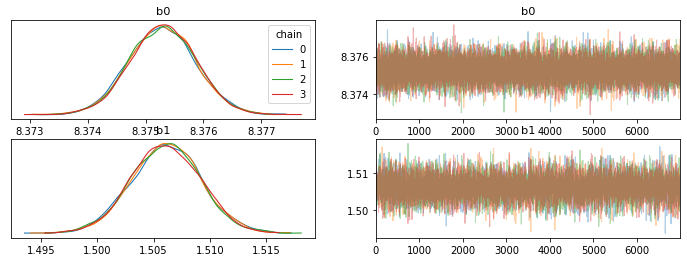

In [ ]:
az.plot_trace(bikeshare_fit1,compact=False, legend=True)
plt.show()

In [ ]:
summ_fit1=az.summary(bikeshare_fit1,round_to=3,hdi_prob=0.95)
summ_fit1

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b0,8.375,0.001,8.374,8.376,0.0,0.0,15789.901,14309.760,1.0
b1,1.506,0.003,1.500,1.512,0.0,0.0,7323.091,8461.102,1.0


In [ ]:
bikeshare_fit1_op=az.from_pystan(posterior=bikeshare_fit1)

INFO:numba.core.transforms:finding looplift candidates


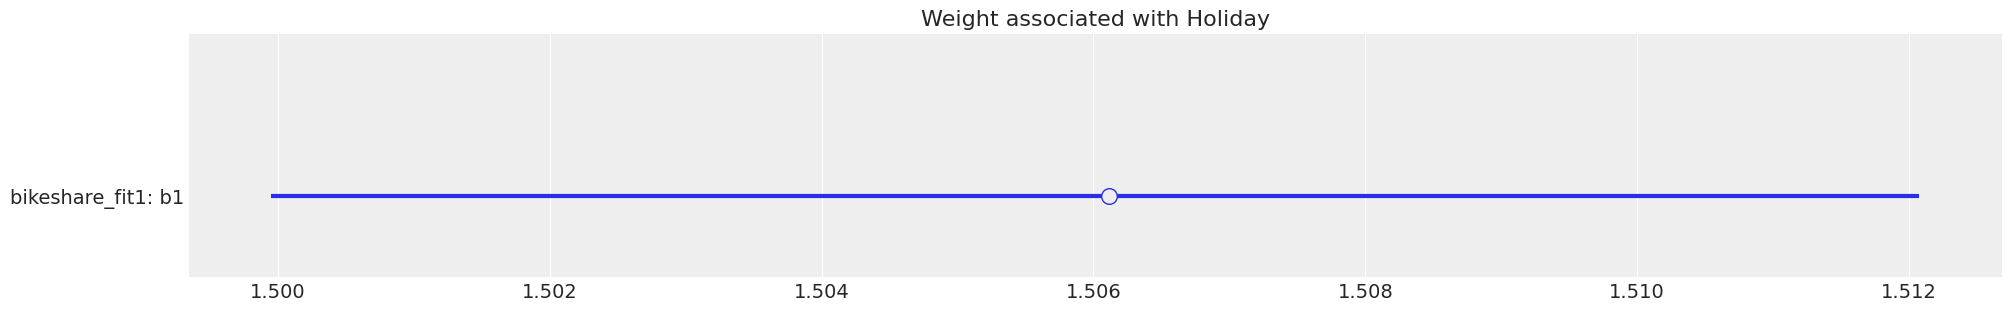

In [ ]:
import matplotlib.pyplot as pylt

az.style.use("arviz-darkgrid")

axes = az.plot_forest([bikeshare_fit1_op], model_names=["bikeshare_fit1"],var_names=['b1'],combined=True,
                      quartiles=False,hdi_prob=0.95,figsize=(20, 3),markersize=15)
axes[0].set_title("Weight associated with Holiday")

plt.show()

# <font color="darkviolet"> Interpretation of Regression Weights

- Weight $\beta$ in Poisson regression associated with a **numeric predictor** $X$ is the expected change (on the log scale) in the outcome $Y$ per unit change in $X$  when all other variables in the model are held constant

  - More precisely, increasing $X$ by $1$ unit multiplies the rate of $Y$ by $e^\beta$

**Estimated Regression Equation is**

$$\hat{\mathrm{log}(cnt)}=\hat\beta_0+\hat\beta_1*temp$$

$$\hat{\mathrm{log}(cnt)}=8.375+1.506*temp$$

## <font color="darkgreen"> Interpretation of weight associated with *temp*

- One unit increase in temp is associated with an increase in the count of bikes rented by a factor $e^{1.506}=4.509$

## <font color="darkgreen"> Interpretation of Intercept

- During average temp (temp is centered) the rental (mean) is $e^{8.375}=4337.27$

#<font color="darkblue"> Poisson GLM with One Binary Predictor

*holiday* is a binary variable - whether the given day is a hoilday or not - Binary levels - *0 or 1*

Let us prepare the data for the model

In [ ]:
bikeshare_da['holiday'] = bikeshare_da['holiday'].astype('category')

In [ ]:
print(bikeshare_da)

In [ ]:
# Input - data and values for prior parameters a and b

n=len(bikeshare_da)
y1=bikeshare_da['cnt']
x1=bikeshare_da['holiday']

bikeshare_data2 = {'N':n,
             'y':y1,
             'x':x1,
             'a_0':0,
             'b_0':10,
             'a_1':0,
             'b_1':10,
            }
bikeshare_data2

In [ ]:
bikeshare_fit2= posterior_fit1.sampling(data=bikeshare_data2,
                  iter=10000,
                  chains=4,
                  seed=1,
                  warmup=3000,
                  thin=1,
                  control={"max_treedepth":15,"adapt_delta" : 0.9999})

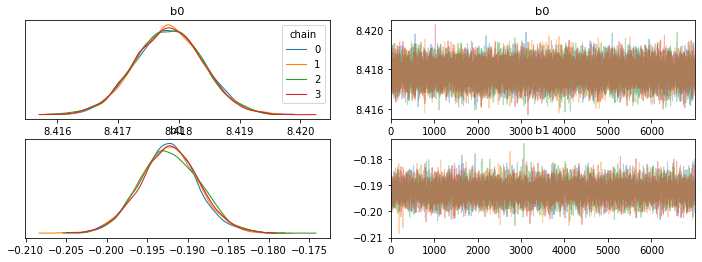

In [ ]:
az.plot_trace(bikeshare_fit2,compact=False, legend=True)
plt.show()

In [ ]:
summ_fit1=az.summary(bikeshare_fit2,round_to=3,hdi_prob=0.95)
summ_fit1

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b0,8.418,0.001,8.417,8.419,0.0,0.0,17973.251,14529.601,1.000
b1,-0.192,0.004,-0.200,-0.185,0.0,0.0,6617.520,7077.738,1.001


In [ ]:
bikeshare_fit2_op=az.from_pystan(posterior=bikeshare_fit2)

INFO:numba.core.transforms:finding looplift candidates


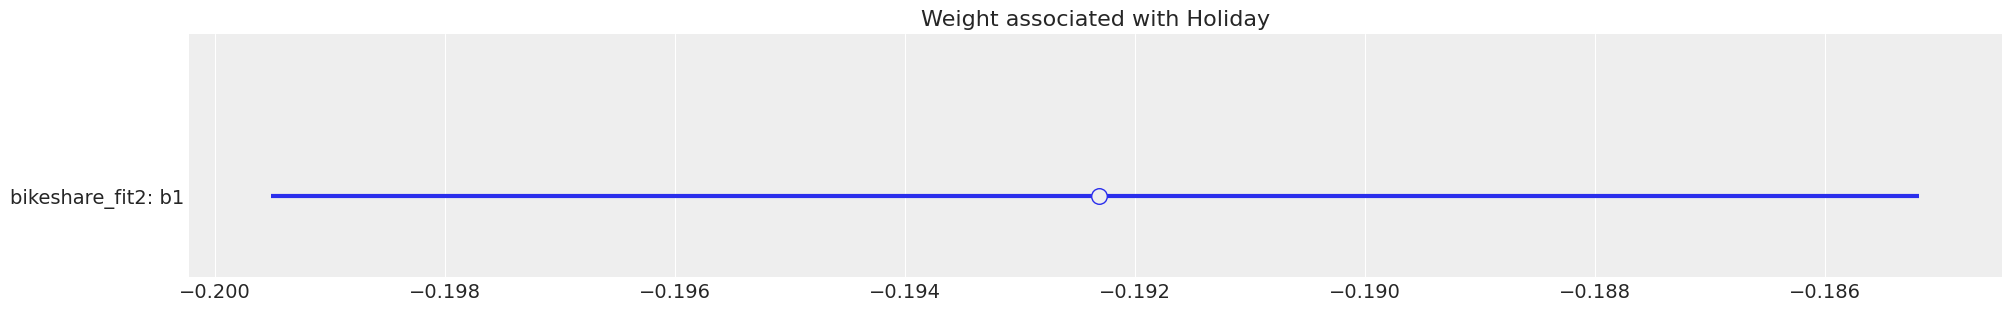

In [ ]:
import matplotlib.pyplot as pylt

az.style.use("arviz-darkgrid")

axes = az.plot_forest([bikeshare_fit2_op], model_names=["bikeshare_fit2"],var_names=['b1'],combined=True,
                      quartiles=False,hdi_prob=0.95,figsize=(20, 3),markersize=15)
axes[0].set_title("Weight associated with Holiday")

plt.show()

# <font color="darkviolet"> Interpretation of Regression Weights

- Weight $\beta$ in Poisson regression associated with a **Binary predictor**
indicates that a level has a $e^\beta$ times more response compared to the response (base) level.

**Estimated Regression Equation is**

$$\hat{\mathrm{log}(cnt)}=\hat\beta_0+\hat\beta_1*holiday$$

$$\hat{\mathrm{log}(cnt)}=8.418-0.192*holiday$$

## <font color="darkgreen"> Interpretation of weight associated with *temp*

- The holiday has a $e^{-0.192}=0.825$ times rental count compared to on holiday.

- Holidays are less likely (0.825 times) to have rental count

## <font color="darkgreen"> Interpretation of Intercept

- During non-holiday (base level) the rental (mean) is $e^{8.418}=4527.84$

# <font color="darkblue"> Models without Predictor

## <font color="darkyellow"> Bayesian Model

$$Y \sim \mathrm{Poisson}(\theta)$$

$$\theta \sim \mathrm{Gamma}(a,b)$$

## <font color="darkred">**About STAN convention**

PDF of Gamma distribution is (Relating $\theta$)

$$p(\theta)=\frac{b^a}{\Gamma(a)}\theta^{a-1}e^{-b\theta}$$ where $\theta>0$ and $a,b>0$

- Mean $=\frac{a}{b}$

- Variance $=\frac{a}{b^2}$

## <font color="darkgreen"> About Prior Parameters

If we want to assign a uniform distribution on $\theta$ then $a=1,b\rightarrow 0$. This leads to an **Improper Prior**; parameter is Uniform in an unbounded interval

Informally, $$\theta \sim \mathrm{Uniform}(0,\infty)$$

Recall, PDF of Continuous Uniform distribution is

$$f(x)=\frac{1}{H-L}$$ where $L<x<H$

## <font color="darkred">**About scipy.gamma convention**

To generate few Gamma distributions to visually understand the shape of prior choices

[Gamma_Scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gamma.html)

$$p(\theta)=\frac{1}{\Gamma(a)s^a}\theta^{a-1}e^{-\frac{\theta}{s}}$$ where $\theta>0$ and $a,s=\frac{1}{\beta}>0$

- gamma.pdf(x, a, loc, scale)

- scale $(s)=\frac{1}{\beta}$

- Mean $=a*\mathrm{scale}$

- Variance $=a*\mathrm{scale}^2$

## <font color="darkgreen"> Prior Parameters - Using Informed Guess

We assume a prior mean as M with variance V then using the above formula it is possible to find values for a and b

**STAN convention**

$$\frac{a}{b}=M$$

$$\frac{a}{b^2}=V$$

Second relation yields

$$\frac{a}{b}\frac{1}{b}=V$$

$$\implies M\frac{1}{b}=V$$

$$\implies b=\frac{M}{V}$$ and hence, from the first relation

$$a=\frac{M^2}{V}$$


In case $M=2$ and $V = 10$, then $a=0.4,b=0.2$

**Scipy convention**

$$a=0.4, s=5$$


In [ ]:
#Calculation to find a and b from "Guessed" mean (M) and Variance (V)
M=2000
V=10
a=M**2/V
b=M/V

print("a = "+str(a),"b = "+str(b))

a = 400000.0 b = 200.0


In [ ]:
from scipy.stats import gamma
G1=gamma.rvs(a=a, loc=0, scale=1/b,size=1000)
np.mean(G1)

1999.9956298110694

In [ ]:
fig,ax = plt.subplots(1,1)
ax.hist(G1)
plt.show()

# <font color="darkblue"> Model 1: Gamma prior on $\theta$

## Conjugate Prior

In [ ]:
bikeshar_code1 = """
data {
    real<lower=0> a;
    real<lower=0> b;
    int<lower=0> k;
    int y[k];
}

parameters {
    real<lower=0> theta;
}


model {
      y ~ poisson(theta);
      theta ~ gamma(a, b);
}
"""
# posterior
posterior1 = pystan.StanModel(model_code=bikeshar_code1)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_2e8ffcea51cbb9b36bdb27ee8788cd9d NOW.


In [ ]:
n=len(bikeshare_da)
bikeshare_data = {
             'k':n,
             'y':bikeshare_da['cnt'],
             'a':a,
             'b':b,
            }
print(bikeshare_data)

In [ ]:
fit_model1= posterior1.sampling(data=bikeshare_data,
                  iter=10000,
                  chains=4,
                  seed=1,
                  warmup=3000,
                  thin=1,
                  control={"max_treedepth":15,"adapt_delta" : 0.9999})

#<font color="darkorange"> MCMC convergence Diagnostics - Plots

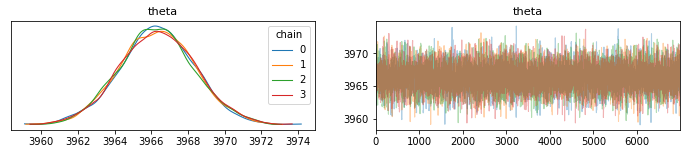

In [ ]:
az.plot_trace(fit_model1, compact=False,legend=True)
plt.show()

# <font color="darkorange"> Condensed Summary Report

In [ ]:
summ_mod1=az.summary(fit_model1,round_to=3,hdi_prob=0.95)
summ_mod1

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,3966.334,2.072,3962.286,3970.482,0.024,0.017,7528.215,6457.745,1.0


In [ ]:
bikeshare_data_op=az.from_pystan(posterior=fit_model1)

INFO:numba.core.transforms:finding looplift candidates


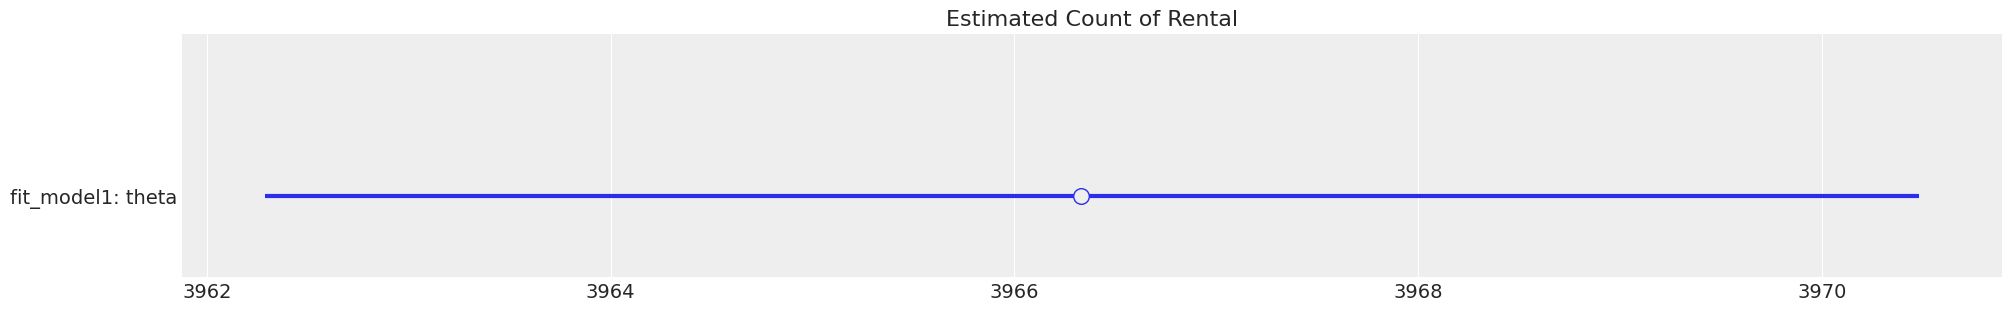

In [ ]:
import matplotlib.pyplot as pylt

az.style.use("arviz-darkgrid")

axes = az.plot_forest([bikeshare_data_op], model_names=["fit_model1"],var_names=['theta'],combined=True,
                      quartiles=False,hdi_prob=0.95,figsize=(20, 3),markersize=15)
axes[0].set_title("Estimated Count of Rental")

plt.show()

In [ ]:
bikeshare_data_op.posterior["theta"]
zz=bikeshare_data_op.posterior["theta"].to_dataframe(name=None, dim_order=None)
len(zz)

28000

In [ ]:
pr1=np.count_nonzero(zz['theta']> 3100, axis=0)/len(zz)

pr2=np.count_nonzero(zz['theta']< 2000, axis=0)/len(zz)

pr3=np.count_nonzero((zz['theta']>3950) & (zz['theta'] < 3970))/len(zz)

print(pr1,pr2,pr3)


1.0 0.0 0.9588928571428571
